[./data/trace.json]


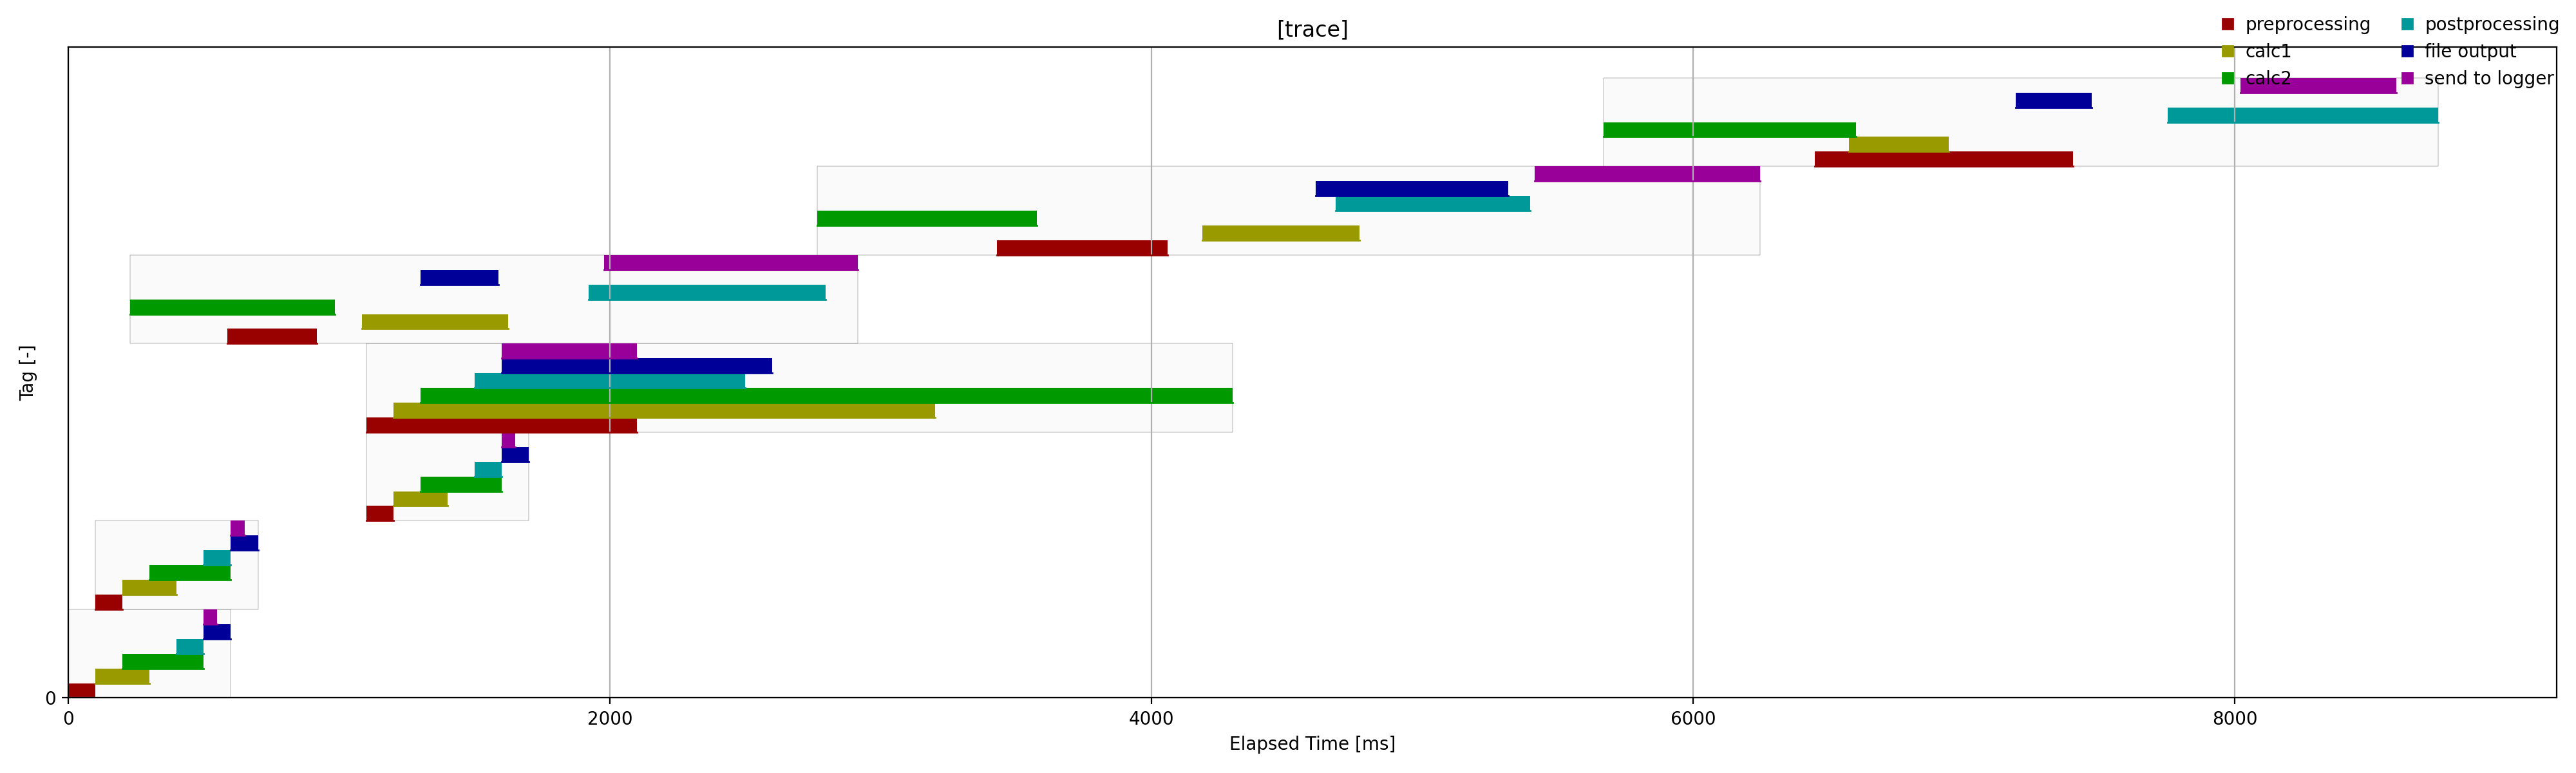

In [58]:
%matplotlib widget
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorsys
import random
import json

# parameters
target_trace_filepath = './data/trace.json'
# target_trace_filepath = '' # if this value is empty (dummy data will be used)
figsize=(20, 6)
new_dummy_data_num = 30
print_name_flag = False
print_tag_flag = False
filter_func = lambda x: True
# filter_func = lambda x: x['tag'] >= 10 and x['tag'] <= 20
# filter_func = lambda x: x['start_time'] >= 1000 and x['start_time'] <= 2000
xaxis_left=0
yaxis_bottom=0

# to avoid 'RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).'
plt.close()

def generate_dummy_data():
    dummy_data = [
        {"name": "preprocessing", "tag": 0, "start_time": 0, "duration": 100},
        {"name": "calc1", "tag": 0, "start_time": 100, "duration": 200},
        {"name": "calc2", "tag": 0, "start_time": 200, "duration": 300},
        {"name": "postprocessing", "tag": 0, "start_time": 400, "duration": 100},
        {"name": "file output", "tag": 0, "start_time": 500, "duration": 100},
        {"name": "send to logger", "tag": 0, "start_time": 500, "duration": 50},
    
        {"name": "preprocessing", "tag": 1, "start_time": 100, "duration": 100},
        {"name": "calc1", "tag": 1, "start_time": 200, "duration": 200},
        {"name": "calc2", "tag": 1, "start_time": 300, "duration": 300},
        {"name": "postprocessing", "tag": 1, "start_time": 500, "duration": 100},
        {"name": "file output", "tag": 1, "start_time": 600, "duration": 100},
        {"name": "send to logger", "tag": 1, "start_time": 600, "duration": 50},
    
        {"name": "preprocessing", "tag": 2, "start_time": 1100, "duration": 100},
        {"name": "calc1", "tag": 2, "start_time": 1200, "duration": 200},
        {"name": "calc2", "tag": 2, "start_time": 1300, "duration": 300},
        {"name": "postprocessing", "tag": 2, "start_time": 1500, "duration": 100},
        {"name": "file output", "tag": 2, "start_time": 1600, "duration": 100},
        {"name": "send to logger", "tag": 2, "start_time": 1600, "duration": 50},
    
        {"name": "preprocessing", "tag": 3, "start_time": 1100, "duration": 1000},
        {"name": "calc1", "tag": 3, "start_time": 1200, "duration": 2000},
        {"name": "calc2", "tag": 3, "start_time": 1300, "duration": 3000},
        {"name": "postprocessing", "tag": 3, "start_time": 1500, "duration": 1000},
        {"name": "file output", "tag": 3, "start_time": 1600, "duration": 1000},
        {"name": "send to logger", "tag": 3, "start_time": 1600, "duration": 500},
    ]
    
    names = set(entry["name"] for entry in dummy_data)
    
    def generate_random_data():
        tag = 4
        name_list = list(names)
        start_time = 300
        while True:
            start_time += random.randint(-100, 150)
            for name in name_list:
                new_entry = {}
                new_entry["name"] = name
                new_entry["tag"] = tag
                new_entry["start_time"] = start_time
                new_entry["duration"] = random.randint(100, 1000)
                start_time += random.randint(0, 1000)
                yield new_entry
            tag += 1
    
    gen = generate_random_data()
    for _ in range(len(names) * new_dummy_data_num):
        dummy_data.append(gen.__next__())
    return dummy_data

# setup data
if target_trace_filepath == "":
    dummy_data = generate_dummy_data()
    data = dummy_data
    print('[dummy data]')
else:
    print('[{}]'.format(target_trace_filepath))
    with open(target_trace_filepath) as f:
        data = json.load(f)

data = list(filter(filter_func, data))
names = set(entry["name"] for entry in data)

sorted_data = sorted(filter(lambda x: x['tag'] == 0, data), key=lambda x: x["start_time"])

name_offset = {}
offset = 0
for entry in sorted_data:
    name_offset[entry['name']] = offset
    offset += 1

for name in names:
    if not name in name_offset:
        name_offset[name] = offset
        offset += 1

# get minimum start time and maximum end time for each tag
tag_times = {}
for entry in data:
    tag = entry["tag"]
    start_time = entry["start_time"]
    end_time = entry["start_time"] + entry["duration"]
    if tag not in tag_times:
        tag_times[tag] = {"start": start_time, "end": end_time}
    else:
        tag_times[tag]["start"] = min(tag_times[tag]["start"], start_time)
        tag_times[tag]["end"] = max(tag_times[tag]["end"], end_time)

# generate colors from names
color_num = len(names)
hues = [i / color_num for i in range(color_num)]
colors = [colorsys.hsv_to_rgb(hue, 1.0, 0.6) for hue in hues]

def get_color_from_name(name):
    color_index = name_offset[name] % len(colors)
    color = colors[color_index]
    return color

fig, ax = plt.subplots(figsize=figsize, dpi=200)

#### /* plot ####
# process each tag individually
for i, tag in enumerate(tag_times):
    start_time = tag_times[tag]["start"]
    end_time = tag_times[tag]["end"]
    duration = end_time - start_time
    
    color_index = i % len(colors)
    color = colors[color_index]
    
    # rectangle enclosing a group of traces of the tag
    rect = Rectangle((start_time, tag + 0.0), duration, 1.0, linewidth=0.1, edgecolor='black', facecolor='#fafafa')
    fig.gca().add_patch(rect)
    
    # plot tag label
    if print_tag_flag:
        plt.text(start_time, tag + 1.05, f"Tag {tag}", ha='center', va='center', fontsize=10, color='black')

# plot traces
lines = []
for i, entry in enumerate(data):
    name = entry["name"]
    color = get_color_from_name(name)

    # plot a line
    y_padding = 0.0 # e.g. 0.2(top padding) ---- 0.6 ----- 0.2(bottom padding) (total 1.0)
    y_step = (1.0 - y_padding * 2) / len(name_offset)
    y = entry["tag"] + y_padding + name_offset[name] * y_step
    start_time = entry["start_time"]
    duration = entry["duration"]
    end_time = start_time + duration
    line, = ax.plot([start_time, end_time], [y, y], color=color, linewidth=1)
    lines += [line]
    rect = Rectangle((start_time, y), duration, y_step, linewidth=2, edgecolor='none', facecolor=color)
    fig.gca().add_patch(rect)

    # plot a trace label
    if print_name_flag:
        plt.text(start_time + duration / 8, y + 0.025, name, fontsize=8, color='white')

# show legends
for name in name_offset:
    color = get_color_from_name(name)
    ax.plot([], [], marker="s", color=color, label=name, linestyle="none")
fig.legend(frameon=False, handletextpad=0, ncol=2, columnspacing=1)
#### plot */ ####

#### /* annotation ####
# create an annotation tooltip
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points", color="white",
                    bbox=dict(boxstyle="round", fc="w", facecolor="black"),
                    arrowprops=dict(arrowstyle="->"))
annot.get_bbox_patch().set_alpha(0.9)
annot.set_visible(False)

def hover(event):
    if event.inaxes == ax:
        hit_flag = False
        for (i, line) in enumerate(lines):
            cont, ind = line.contains(event)
            if cont:
                x,y = line.get_data()
                annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
                line_metadata = data[i]
                start_time = line_metadata["start_time"]
                duration = line_metadata["duration"]
                line_metadata['end_time'] = start_time + duration
                name = line_metadata["name"]
                text = "\n".join(["{}: {}".format(key, value) for key, value in line_metadata.items()])
                annot.get_bbox_patch().set_facecolor(get_color_from_name(name))
                annot.set_text(text)
                hit_flag = True
                break
        if hit_flag is False:
            vis = annot.get_visible()
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
        else:
            annot.set_visible(True)
            fig.canvas.draw_idle()
    return

    if event.inaxes == ax:
        cont, ind = ax.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
               annot.set_visible(False)
               fig.canvas.draw_idle()
fig.canvas.mpl_connect("motion_notify_event", hover)
#### annotation */ ####

plt.title('[trace]')
plt.xlabel('Elapsed Time [ms]')
plt.ylabel('Tag [-]')
plt.xlim(left=xaxis_left)
plt.ylim(bottom=yaxis_bottom)
plt.yticks(range(int(min(plt.yticks()[0])), int(max(plt.yticks()[0])), 10))

plt.grid(True)
plt.tight_layout()
plt.show()